In [1]:
import numpy as np
from numpy import typing as npt
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from pyrlmala.utils.target import AutoStanTargetPDF
from typing import Callable, Optional, Tuple

In [2]:
LATEX_STYLE = True

if LATEX_STYLE:
    plt.rcParams.update(
        {
            "text.usetex": True,
            "font.family": "serif",
            "font.serif": ["Computer Modern Roman"],
        }
    )

plt.rcParams.update(
    {
        "font.size": 24,
        "axes.titlesize": 28,
        "axes.labelsize": 26,
        "xtick.labelsize": 20,
        "ytick.labelsize": 20,
        "legend.fontsize": 16,
    }
)

In [3]:
posteriordb_path = "../posteriordb/posterior_database"

In [4]:
target_laplace_1 = AutoStanTargetPDF("test-laplace_1-test-laplace_1", posteriordb_path)
target_laplace_2 = AutoStanTargetPDF("test-laplace_2-test-laplace_2", posteriordb_path)
target_neals_funnel = AutoStanTargetPDF("test-neals_funnel-test-neals_funnel", posteriordb_path)
target_banana = AutoStanTargetPDF("test-banana-test-banana", posteriordb_path)
target_skew_t = AutoStanTargetPDF("test-skew_t-test-skew_t", posteriordb_path)

In [5]:
def target_plot_2d(
    ax: plt.Axes,
    x_mesh_range: Tuple[float, float, int],
    y_mesh_range: Tuple[float, float, int],
    log_target_pdf: Callable[[np.ndarray], float],
    *,
    norm,
    levels: np.ndarray,
    cmap: str = "viridis",
    show_ticks: bool = True,
    n_xticks: int = 5,
    n_yticks: int = 5,
):
    """
    ax:            接受外部传入的 Axes
    show_ticks:    是否显示刻度
    n_xticks:      x 轴打几个刻度
    n_yticks:      y 轴打几个刻度
    """
    # 1) 网格
    x0, x1, nx = x_mesh_range
    y0, y1, ny = y_mesh_range
    mesh_x, mesh_y = np.meshgrid(
        np.linspace(x0, x1, nx),
        np.linspace(y0, y1, ny),
    )
    data = np.stack([mesh_x.ravel(), mesh_y.ravel()], axis=1)

    # 2) 计算密度
    vals = np.exp([log_target_pdf(pt) for pt in data])
    Z = vals.reshape(ny, nx)  # 注意 reshape 顺序：rows=ny, cols=nx

    # 3) 等高线填色
    cf = ax.contourf(
        mesh_x, mesh_y, Z,
        levels=levels,
        norm=norm,
        cmap=cmap,
        extend='neither'
    )

    # 4) 坐标轴刻度
    if show_ticks:
        ax.set_xticks(np.linspace(x0, x1, n_xticks))
        ax.set_yticks(np.linspace(y0, y1, n_yticks))
        ax.tick_params(axis='both', which='major', labelsize=plt.rcParams['xtick.labelsize'])
    else:
        ax.set_xticks([])
        ax.set_yticks([])

    ax.set_aspect('auto')  # 或 'equal' + adjustable='datalim'
    return cf


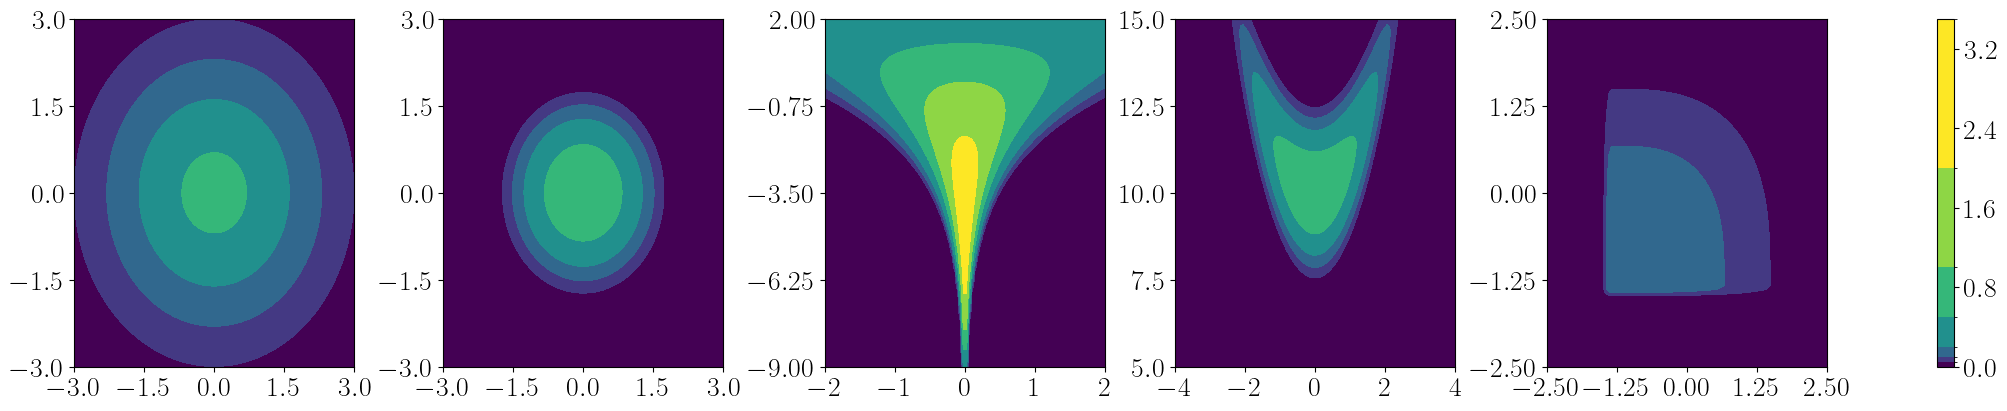

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

# —— 1) 非均匀分段 & norm ——
boundaries = np.array([0.00, 0.05, 0.10, 0.20, 0.50, 1.00, 2.00, 3.5])
cmap = plt.cm.viridis
norm = BoundaryNorm(boundaries, ncolors=cmap.N, clip=True)

# —— 2) 五个 log_pdf 函数 & 对应的网格范围 ——
funcs = [
    target_laplace_1.log_target_pdf,
    target_laplace_2.log_target_pdf,
    target_neals_funnel.log_target_pdf,
    target_banana.log_target_pdf,
    target_skew_t.log_target_pdf,
]
mesh_ranges = [
    ((-3, 3, 100), (-3, 3, 100)),
    ((-3, 3, 100), (-3, 3, 100)),
    ((-2, 2, 100), (-9, 2, 100)),
    ((-4, 4, 100), (5, 15, 100)),
    ((-2.5, 2.5, 100), (-2.5, 2.5, 100)),
]

# —— 3) 建图 ——
fig, axes = plt.subplots(
    1, 5,
    figsize=(20, 4),
    subplot_kw={'aspect': 'auto'},   # ← 关键
    constrained_layout=True
)

for ax, f, (x_rng, y_rng) in zip(axes, funcs, mesh_ranges):
    target_plot_2d(
        ax,
        x_mesh_range=x_rng,
        y_mesh_range=y_rng,
        log_target_pdf=f,
        norm=norm,
        levels=boundaries,
        cmap=cmap,
    )

# 共享 colorbar
cbar = fig.colorbar(
    plt.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=axes,
    boundaries=boundaries,
    spacing='proportional',
    ticks=boundaries,
)
cbar.locator = MaxNLocator(nbins=5)  # 最多 5 个刻度
plt.savefig("target_share_plot.pdf", bbox_inches='tight')

In [7]:
# 拿到 colorbar 的 Axes
cbar_ax = cbar.ax  

# 查看它在 figure 坐标系中的位置：返回一个 Bbox(x0, y0, x1, y1)
pos = cbar_ax.get_position()
print("Colorbar axes Bbox:", pos)

# 宽度 fraction 就是 pos.width
print(f"Colorbar width fraction of figure: {pos.width:.3f}")


Colorbar axes Bbox: Bbox(x0=0.9656008857109063, y0=0.09622524434196415, x1=0.9742942326292888, y1=0.9655599361802151)
Colorbar width fraction of figure: 0.009


In [8]:
main_ax = axes[0]      # 或者你的热图 Axes 列表里的任意一个
main_pos = main_ax.get_position()
fraction_vs_main = pos.width / main_pos.width
print(f"Colorbar width relative to main axes: {fraction_vs_main:.3f}")


Colorbar width relative to main axes: 0.062
